In [129]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pyproj
from scipy.interpolate import griddata
import cftime
from sklearn.linear_model import LinearRegression

In [130]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
era = xr.open_dataset(home_path + path + "/ae3baa6a74f0aa315dc3de6f83298f0e.nc")

path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'


In [195]:
# pr has units m -> convert to mm / kg m^2
pr = era["tp"] * 1000


lats = era["latitude"].values
lons = era["longitude"].values

# Compute number of days in each month (xarray provides days_in_month)
days_in_month = pr["valid_time"].dt.days_in_month
seconds_in_month = days_in_month 

# Convert monthly mean rate (mm/s) → monthly total (mm)
pr_monthly_total = pr * seconds_in_month

# Restrict to 1979–2000
pr_sel = pr_monthly_total.sel(valid_time=slice("1979-01-01", "2000-12-31"))

# Group by year and sum over months
pr_annual = pr_sel.groupby("valid_time.year").sum("valid_time")

# pr_annual is now ERA5 (year, lat, lon) with units mm/year
print(pr_annual.shape)

(22, 301, 3600)


In [250]:
print(era.variables['longitude'][1])

<xarray.Variable ()> Size: 8B
array(-179.9)
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude


In [287]:
# Mapping the ice core locations to ERA5 indices
prCoords = pd.read_csv(home_path + path + "/AccumCoresCoords.csv", header=None)
coresLat = prCoords.iloc[:, 2].values
coresLonFirst = prCoords.iloc[:, 3].values
coresLon = (coresLonFirst + 360) % 360

# Select a numeric variable from your Dataset, e.g., 'tp' (replace with your variable name)
era_var = era["tp"]  # replace 'tp' with your actual variable name

lat_idx = []
lon_idx = []
grid_lats = []
grid_lons = []

i = 0
for la, lo in zip(coresLat, coresLon):
    # Compute distances to all grid points
    lons[lons < 0] += 360  # Adjust longitudes to be in the range [0, 360]

    lat_diff = np.abs(lats - la)[:, None]  # (n_lat, 1)
    lon_diff = np.abs(lons - lo)[None, :]  # (1, n_lon)
    lat_ind = np.argmin(lat_diff)
    lon_ind = np.argmin(lon_diff)
    lat_min = lats[lat_ind]
    lon_min = lons[lon_ind]

    grid_lats.append(float(lat_min))
    grid_lons.append(float(lon_min))
    lat_idx.append(lat_ind)
    lon_idx.append(lon_ind)
    i += 1


    

# Store results back in DataFrame
prCoords["lat_idx"] = lat_idx
prCoords["lon_idx"] = lon_idx
prCoords["grid_lat"] = grid_lats
prCoords["grid_lon"] = grid_lons

print(prCoords.head())

                       0                       1        2       3  lat_idx  \
0  vrs-13 (vostok stack)  Vostok composite VRS13 -78.4700  106.83      185   
1              B31 3.43W           B31Site DML07 -75.5800   -3.43      156   
2           B32 0.00667E           B32Site DML05 -75.0000   -0.01      150   
3            B33 6.4983E           B33Site DML17 -75.1700    6.50      152   
4              FB96DML01               FB96DML01 -74.8583   -2.55      149   

   lon_idx  grid_lat  grid_lon  
0     2868     -78.5     106.8  
1     1766     -75.6     356.6  
2     1800     -75.0     360.0  
3     1865     -75.2       6.5  
4     1775     -74.9     357.5  


In [257]:
# The ice core accumulation records
accumData = pd.read_csv(home_path + path + "/AccumCoresData.csv", header=None)
print(accumData)

              0                      1          2             3            4   \
0    Site number                      1          2             3            4   
1           Year  vrs-13 (vostok stack)  B31 3.43W  B32 0.00667E  B33 6.4983E   
2           2020                    NaN        NaN           NaN          NaN   
3           2019                    NaN        NaN           NaN          NaN   
4           2018                    NaN        NaN           NaN          NaN   
..           ...                    ...        ...           ...          ...   
218         1804                  39.93       69.6          69.5         31.7   
219         1803                  17.04       75.7            78         41.1   
220         1802                  26.64       66.2          63.3         45.1   
221         1801                   5.79         52          62.9         44.6   
222         1800                  30.37         79          80.8         45.7   

            5          6   

In [258]:
# The ERA5 metrics
era5Metrics = np.array(pd.read_csv(home_path + path + '/ERA5Metrics.csv'))

era5_accum_ais = era5Metrics[:, 1]
era5_accum_wais = era5Metrics[:, 2]
era5_accum_eais = era5Metrics[:, 3]
era5_temp_ais = era5Metrics[:, 4]
era5_temp_wais = era5Metrics[:, 5]
era5_temp_eais = era5Metrics[:, 6]

In [313]:
# The ice core accumulation data

accumCores = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= 1979) & (accumData.iloc[2:, 0].astype(int) <= 2000)
].to_numpy()[::-1]
accumCores = accumCores.astype(float)

accumCoordsInd = prCoords.iloc[:, 4:6].to_numpy()
accumCoordsCoords = prCoords.iloc[:, 2:4].to_numpy()



In [314]:
# Performing the proxy/local regression
n_years, n_lat, n_lon = pr_annual.shape
n_cores = accumCores.shape[1]

# Initialize array to store local ERA5 time series at proxy locations
localERA5 = np.zeros((n_years, n_cores))

for i in range(n_cores):
    lat_idx, lon_idx = accumCoordsInd[i]
    localERA5[:, i] = pr_annual[:, lat_idx, lon_idx]

In [ ]:
n_years, n_cores = accumCores.shape
alphas = np.zeros(n_cores) # y-intercept
betas = np.zeros(n_cores) # slope
R = np.zeros(n_cores) # error variance for r values

for i in range(n_cores):
    y = accumCores[:, i]            # proxy
    X = localERA5[:, i]             # ERA5 local
    # Mask out NaNs
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    y_valid = y[valid_mask]
    X_valid = X[valid_mask].reshape(-1, 1)
    
    if len(y_valid) > 1:  # need at least 2 points
        model = LinearRegression().fit(X_valid, y_valid)
        alphas[i] = model.intercept_
        betas[i] = model.coef_[0]
        residuals = y_valid - model.predict(X_valid)
        sigma_eps[i] = np.var(residuals, ddof=1)
    else:
        # Handle proxies with insufficient data
        alphas[i] = np.nan
        betas[i] = np.nan
        sigma_eps[i] = np.nan

In [306]:
correlations = np.zeros(n_cores)

for i in range(n_cores):
    y = accumCores[:, i]
    X = localERA5[:, i]
    
    # Mask out NaNs
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    y_valid = y[valid_mask]
    X_valid = X[valid_mask]
    
    if len(y_valid) > 1:
        correlations[i] = np.corrcoef(y_valid, X_valid)[0, 1]
    else:
        correlations[i] = np.nan

In [310]:
correlations_metric = np.zeros(n_cores)

for i in range(n_cores):
    y = accumCores[:, i]   # proxy series (22,)
    X = era5_accum_ais         # ERA5 metric (22,)
    
    # Mask NaNs in either series
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    y_valid = y[valid_mask]
    X_valid = X[valid_mask]

    
    if len(y_valid) > 1:
        correlations_metric[i] = np.corrcoef(y_valid, X_valid)[0, 1]
    else:
        correlations_metric[i] = np.nan

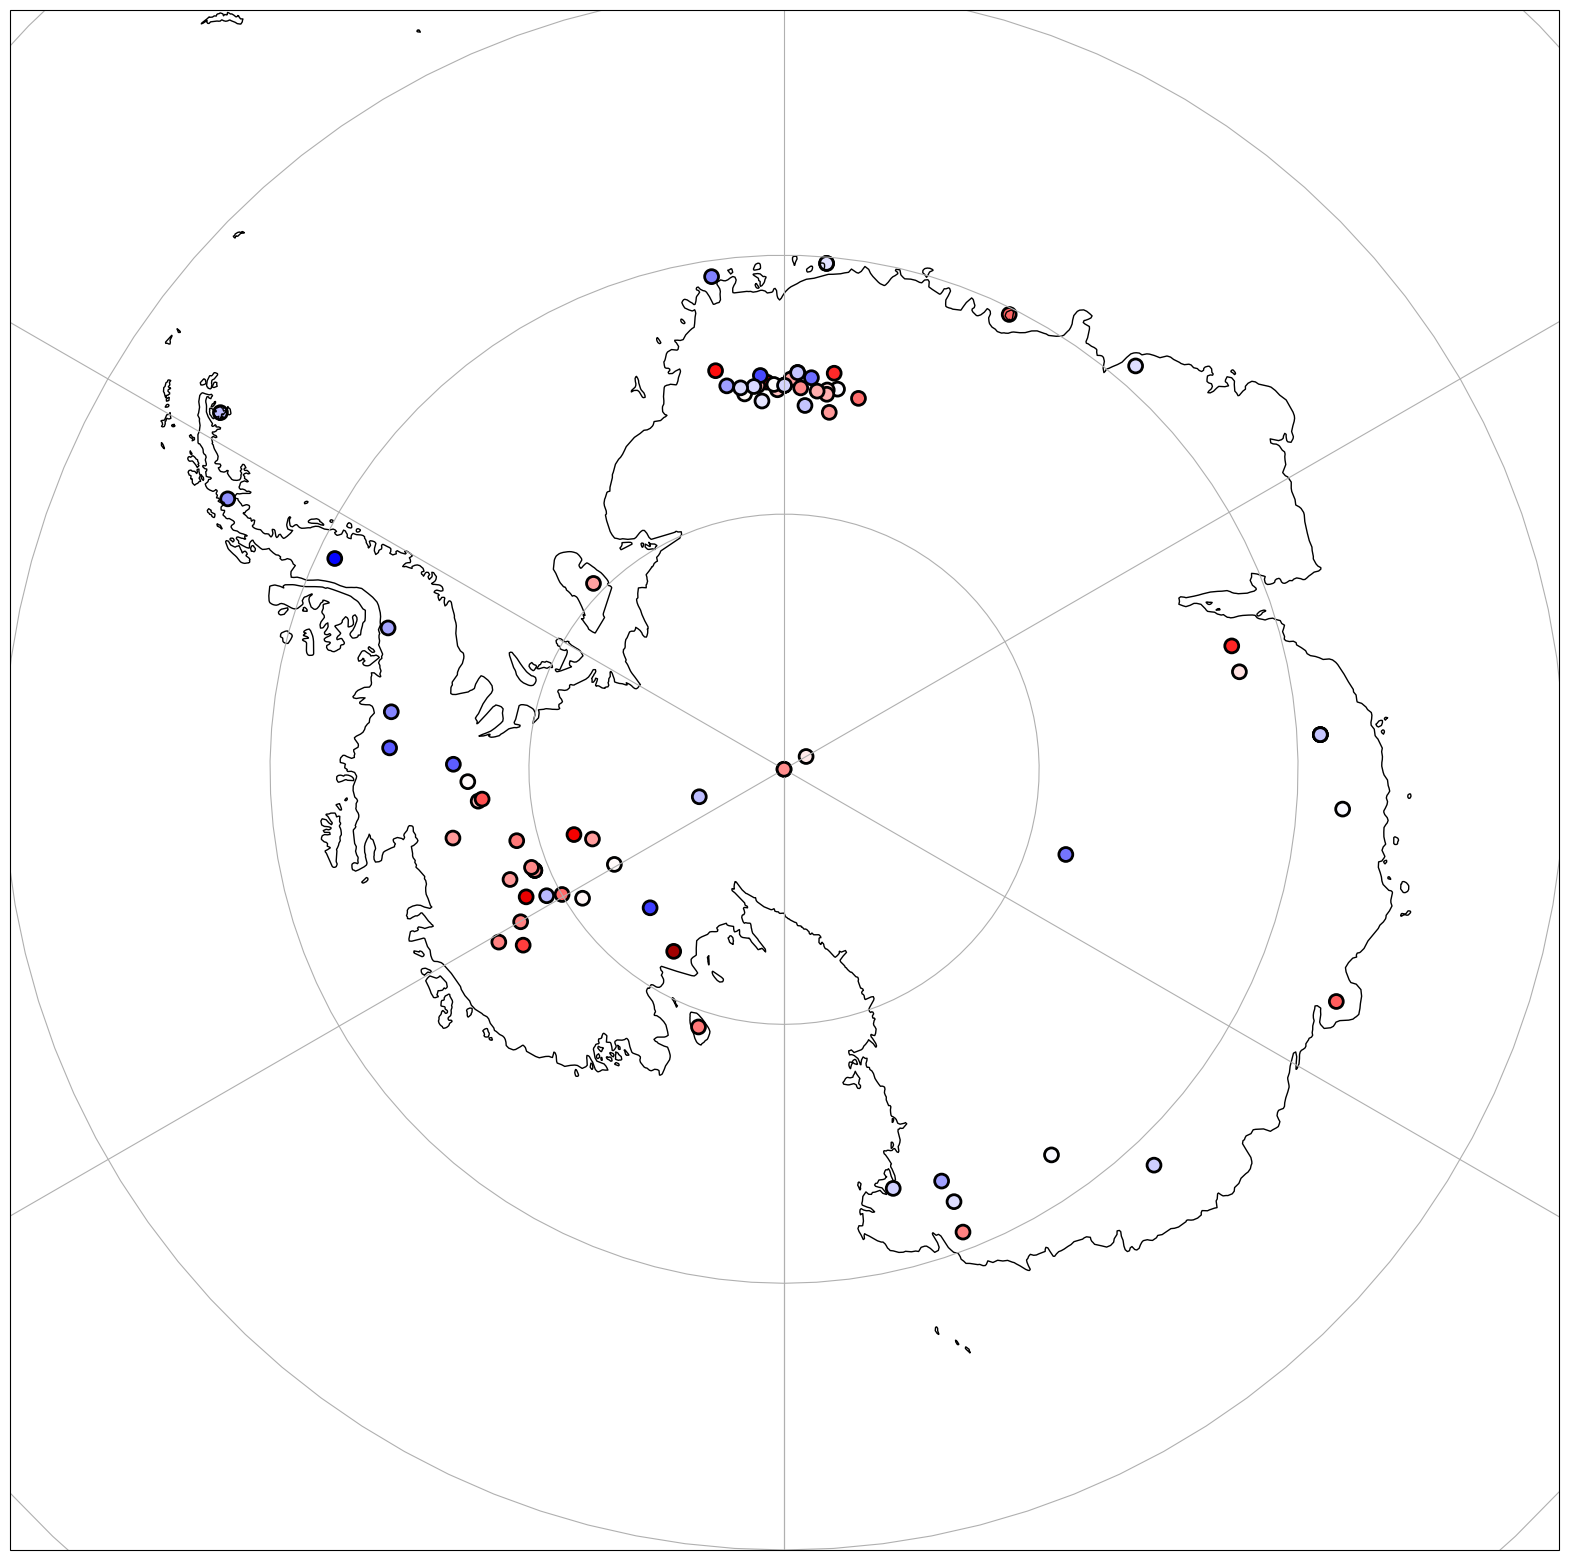

In [311]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.gridlines()

plt.rcParams['figure.figsize'] = [20, 20]


ax.coastlines()
plt.scatter(accumCoordsCoords[:, 1], accumCoordsCoords[:, 0], c=correlations_metric[:], s=100, linewidth=2, edgecolors='black', alpha=1, cmap=plt.cm.seismic, vmin=-1, vmax=1, zorder=1, transform=ccrs.PlateCarree())

#plt.legend(fontsize=29)
#plt.scatter(crLon, crLat, c='yellow', s=500, transform=ccrs.PlateCarree())
plt.show()


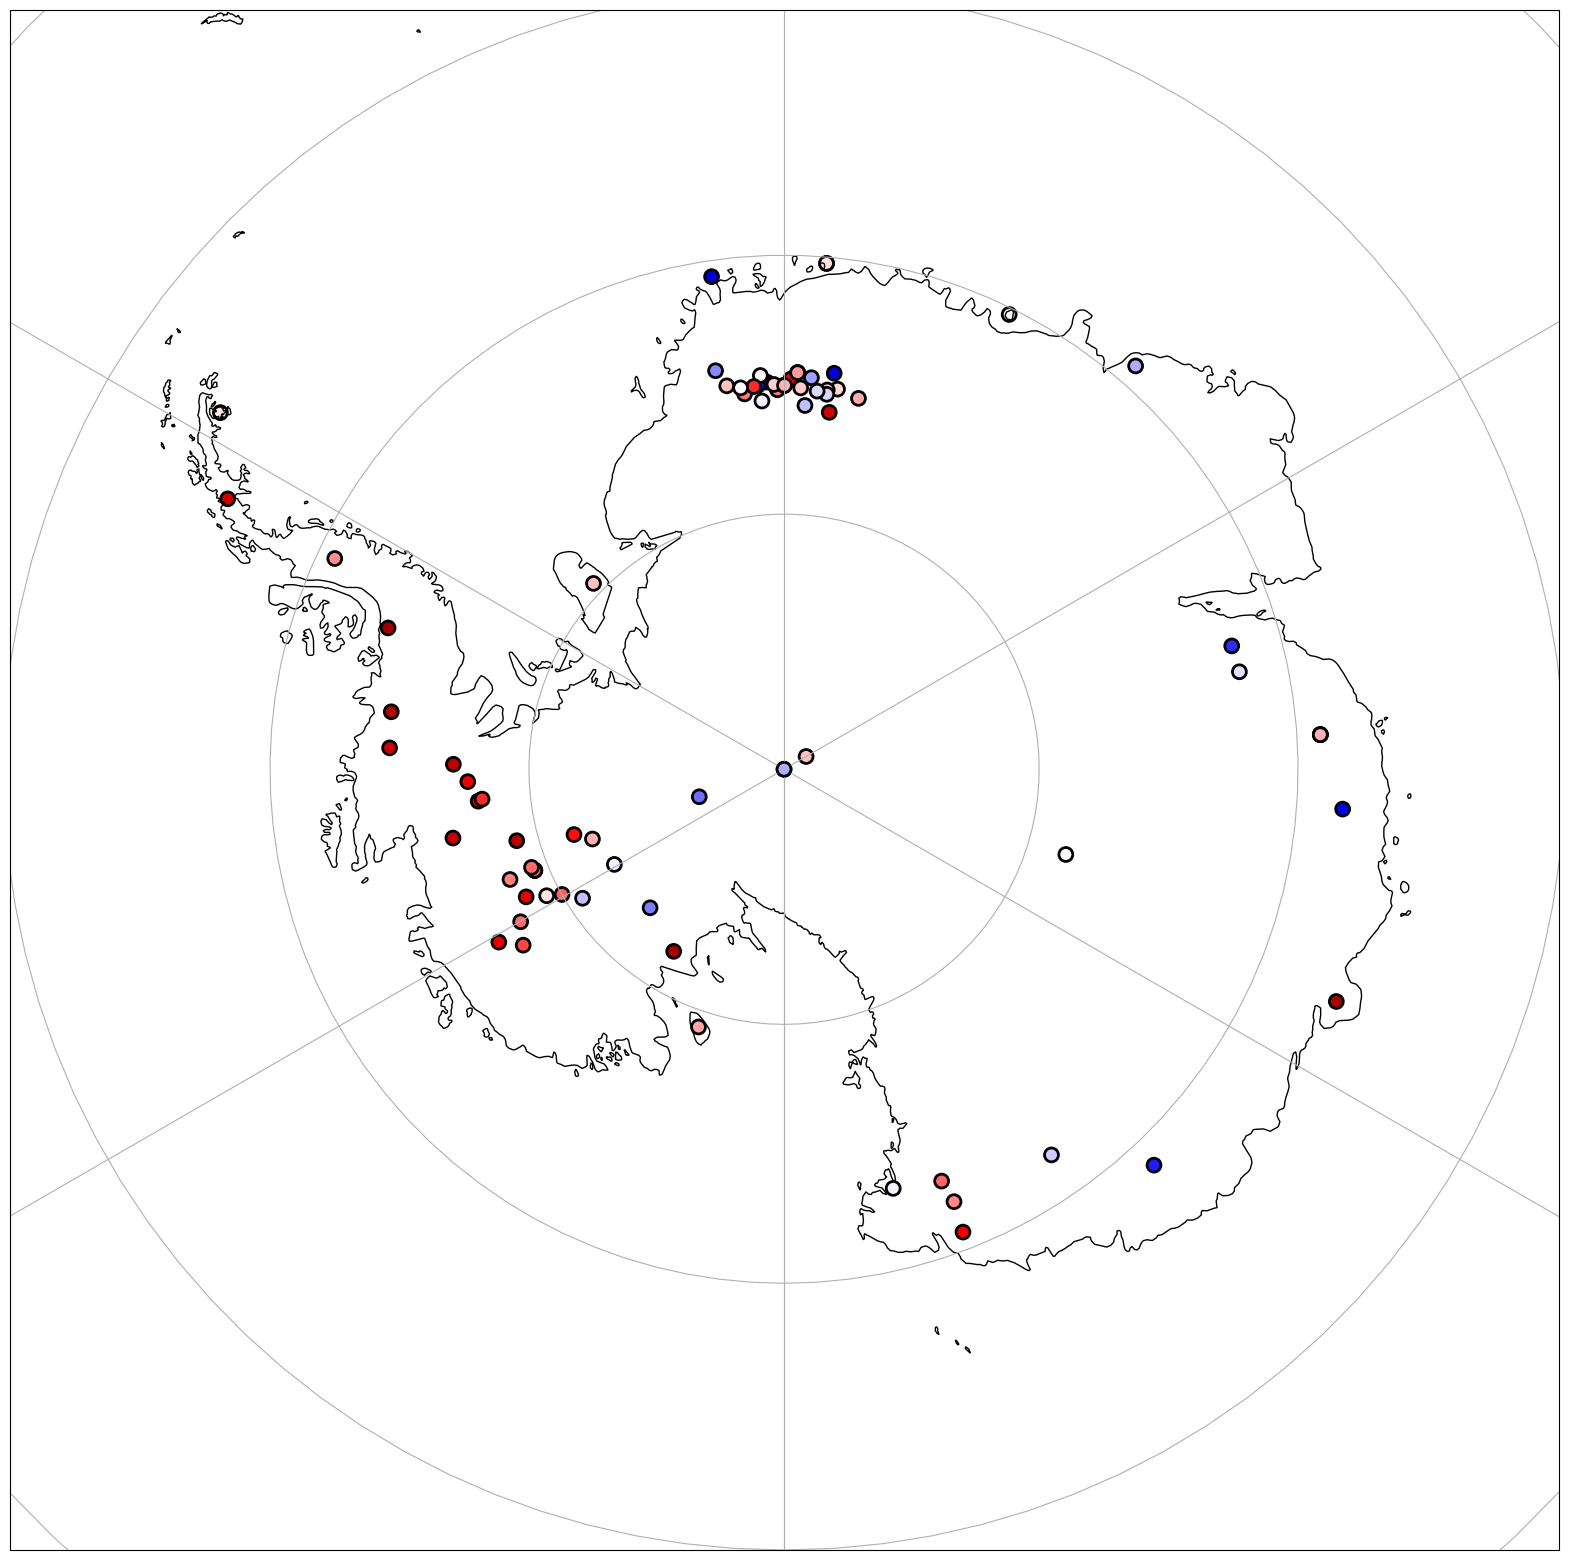

In [312]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.gridlines()

plt.rcParams['figure.figsize'] = [20, 20]


ax.coastlines()
plt.scatter(accumCoordsCoords[:, 1], accumCoordsCoords[:, 0], c=correlations[:], s=100, linewidth=2, edgecolors='black', alpha=1, cmap=plt.cm.seismic, vmin=-1, vmax=1, zorder=1, transform=ccrs.PlateCarree())

#plt.legend(fontsize=29)
#plt.scatter(crLon, crLat, c='yellow', s=500, transform=ccrs.PlateCarree())
plt.show()


In [316]:
for i in range(84):
    print(correlations[i])

-0.0068089607289999
-0.03123215714572704
-0.26230341791663336
-0.25875317020715466
-0.5351340233962049
-0.4443825634283518
-0.35245534366891
-0.596464654938133
-0.24950872781510694
0.07587111256794814
0.019833526044268645
-0.12093046314967308
0.6655330060894519
0.17114092987513146
0.12183325450450559
0.2581686314081184
0.26038169872378997
0.07825103139247583
0.5714017246824606
0.1928229900393007
-0.18259714387765197
0.1037803313713313
-0.08400522673688546
-0.0746625188018732
0.10210991278737701
0.09402225168170478
0.4141488812167682
0.004860151180366531
0.31888574981428036
-0.0983864072171268
-0.43976544991860567
-0.05495887921481641
0.11981273600121609
-0.28179882023486064
0.8440057337921802
-0.5110010220456913
0.12154944963955618
0.8735934308918933
0.045711709803909095
0.22375010237733461
0.6681352103016355
-0.4131453293056759
0.7020159860167824
0.8054125476212644
0.7225785978661297
0.5886286024295594
0.7608050839202773
0.5778240291310016
0.5867746437931626
0.29267825522075763
-0.028